In [1]:
using Roots
using ExcelReaders
using TimeSeries
using Dates
using DataFrames
using PyPlot
using Statistics
using SparseArrays 
using NamedArrays
using StatsBase
using LaTeXStrings

# Replicating Shimer's (2012) exercise 

In this notebook we will replicate key parts of Shimer's (2012) paper studied in the lectures. 

## Data

In the folder you can find an excel file `stocks_data.xls` with time series on employment, unemployment and short-term unemployment (less than 4 weeks at count date) in levels (thousands of workers). (As with Shimer) all series were downloaded from BLS  from [https://www.bls.gov/cps/](https://www.bls.gov/cps/). We use all the data from January 1948 (when the series on short term unemployment becomes available) to December 2019 (so not including the Covid recession).

While the data is the same as Shimer's he uses some additional data to address an issue with a change in measurement of short term unemployed since 1994. This correction has quite minimal implications for the results, but also requires quite a bit more code, so we will not do it and use the raw data directly. (If you are extremely careful) you may notice tiny differences with respect to the results in the paper and the lecture.


First, load the data:

In [2]:
using ExcelReaders

data = readxlsheet("stocks_data.xls", "Sheet1")

865×4 Matrix{Any}:
 "Month"            "E"      "U"      "Us"
 "Jan\n1948"   58061.0   2034.0   1188.0
 "Feb\n1948"   58196.0   2328.0   1377.0
 "Mar\n1948"   57671.0   2399.0   1279.0
 "Apr\n1948"   58291.0   2386.0   1461.0
 "May\n1948"   57854.0   2118.0   1146.0
 "Jun\n1948"   58743.0   2214.0   1287.0
 "Jul\n1948"   58968.0   2213.0   1259.0
 "Aug\n1948"   58456.0   2350.0   1511.0
 "Sep\n1948"   58513.0   2302.0   1245.0
 "Oct\n1948"   58387.0   2259.0   1210.0
 "Nov\n1948"   58417.0   2285.0   1251.0
 "Dec\n1948"   58740.0   2429.0   1432.0
 ⋮                                
 "Jan\n2019"  156529.0   6439.0   2303.0
 "Feb\n2019"  156908.0   6115.0   2246.0
 "Mar\n2019"  156755.0   6182.0   2174.0
 "Apr\n2019"  156683.0   5911.0   1942.0
 "May\n2019"  156814.0   5941.0   2131.0
 "Jun\n2019"  157164.0   5909.0   1903.0
 "Jul\n2019"  157525.0   6008.0   2102.0
 "Aug\n2019"  157782.0   5981.0   2276.0
 "Sep\n2019"  158302.0   5775.0   1853.0
 "Oct\n2019"  158474.0   5957.0   1946.0
 

Now just load the data into vectors `E`, `U` and `Us`, with the data values of total number of employed, unemployed and short term unemployed (in thousands). 

In [3]:
E = float.(data[2:end,2])
U = float.(data[2:end,3])
Us = float.(data[2:end,4])

864-element Vector{Float64}:
 1188.0
 1377.0
 1279.0
 1461.0
 1146.0
 1287.0
 1259.0
 1511.0
 1245.0
 1210.0
 1251.0
 1432.0
 1510.0
    ⋮
 2303.0
 2246.0
 2174.0
 1942.0
 2131.0
 1903.0
 2102.0
 2276.0
 1853.0
 1946.0
 2063.0
 2102.0

Also create a nice vector of the months within the data (don't want to use the entries from the Excel file as labels are strings)

In [4]:
using Dates
months  = collect(Date(1948,1,1):Dates.Month(1):Date(2019,12,1))

864-element Vector{Date}:
 1948-01-01
 1948-02-01
 1948-03-01
 1948-04-01
 1948-05-01
 1948-06-01
 1948-07-01
 1948-08-01
 1948-09-01
 1948-10-01
 1948-11-01
 1948-12-01
 1949-01-01
 ⋮
 2019-01-01
 2019-02-01
 2019-03-01
 2019-04-01
 2019-05-01
 2019-06-01
 2019-07-01
 2019-08-01
 2019-09-01
 2019-10-01
 2019-11-01
 2019-12-01

For the graphical analysis, I also load data on recessions (which will allow us to shade the regions of the graphs when recessions happen). Don't worry about the below code - just note that the outcome of all this is to produce a vector of the start and end months of the 11 US recessions in our time frame.

In [5]:
data_recessions = readxlsheet("recessions.xls", "Sheet1")

dates1 = Date.(data_recessions[:,1])
recessions1 = data_recessions[:,2]

aux1 = zeros(length(dates1))
aux2 = ones(length(dates1))

date_rec_start = aux1.==aux2
date_rec_end = aux1.==aux2

for i = 2:length(dates1)-1
    date_rec_start[i] = recessions1[i]==1.0&&recessions1[i-1]==0.0
    date_rec_end[i] = recessions1[i]==1.0&&recessions1[i+1]==0.0
end

rec_startdates = dates1[date_rec_start];
rec_enddates = dates1[date_rec_end];

## Measuring job-finding probabilities and rates

As seen in the lecture, under the assumption of constant Poisson job-finding rate within a month and only two employment states, Shimer demonstrates that the job-finding probability can be found from observables as

$$ F_t = 1-\frac{u_{t+1}-u_{t+1}^s}{u_t} $$

Then the job-finding rate is simply

$$ f_t = -\log(1-F_t)$$

Let's construct the series using the data:

In [6]:
F = 1 .- (U[2:end]-Us[2:end])./U[1:end-1]
f = -log.(1 .- F)

863-element Vector{Float64}:
 0.760245514063115
 0.7316808445621881
 0.9530135253272695
 0.8980177981974223
 0.8262739605954966
 0.8418924418202957
 0.9698936335838433
 0.7989806212679669
 0.7859409808855308
 0.7814874613996289
 0.8293705333664669
 0.8049784285082917
 0.7340333784765822
 ⋮
 0.4348486244140781
 0.5093771728376705
 0.422452405356572
 0.4431276699089962
 0.4391858327036228
 0.39408423212997784
 0.41396277990905034
 0.48340865571378344
 0.42198605028826547
 0.3644976696199414
 0.4370134658430903
 0.45027066512811575

## Find separation probabilities and rates

Further assuming labour-force to be constant during each month, Shimer shows that the separation rate $x_t$ solves 

$$ u_{t+1} = \frac{(1-e^{-f_t-x_t})x_t}{f_t + x_t}(u_t+e_t) + e^{-f_t-x_t}u_t $$

Using data for unemployment, employment and job-finding rate (already computed), the separration rate, $x_t$, is the solution to this nonlinear equation. 

If we were to not consider time aggregation explicitly we may have been looking at separation probabilities determined by

$$u_{t+1} = \tilde{X}_t e_t + (1-\tilde{F}_t) u_t $$ 

and if we assume $\tilde{F}_t = F_t$, then we can obtain the separation probability as

$$\tilde{X}_t = \frac{u_{t+1}^s}{e_t}$$

We will plot this to see the implications for the importance of time aggregation.

In [7]:
using Roots

## Find the corresponding separation rates

fzbase(x,f,u_f,U,E) = u_f - (((1-exp(-f-x))*x)/(f+x))*(U+E)-exp(-f-x)*U;

x,X = similar(f),similar(F)

for i in 1:length(x)
    fz(x) = fzbase(x,f[i],U[i+1],U[i],E[i])
    x[i] = fzero(fz,0,1)
    X[i] = 1-exp(-x[i])
end

## And the separation rate not accounting time aggregation

x_tilde,X_tilde = similar(f),similar(F)

for i in 1:length(x)
    X_tilde[i] = Us[i+1]/E[i]
    x_tilde[i] = -log(1-X_tilde[i])
end

Note that we have one less observation for the rates than for the stocks as calculation of rates at time $t$ require the stocks at $t$ and $t+1$

For later, let's construct a time series of the monthly unemployment rate and monthly steady state unemployment rate.

In [8]:
u = U[2:end]./(U[1:end-1]+E[1:end-1])
u0 = (x./(x.+f))

863-element Vector{Float64}:
 0.04277282557728799
 0.040662555863497554
 0.03959283150496614
 0.03201694319207006
 0.0380935648381711
 0.036292524529714223
 0.039693451426177306
 0.0372476248950398
 0.03658470444202371
 0.03801975491869879
 0.04173894189424338
 0.04450479941195132
 0.05045038357268768
 ⋮
 0.03998790208934809
 0.034661990344022606
 0.038665778099716115
 0.033418181162150125
 0.03685822690782963
 0.03591673705262568
 0.03797139983640635
 0.03632020010087299
 0.03296506119164241
 0.038711854365771674
 0.03546011227639922
 0.035253473517654246


Observe how our data looks like

In [9]:
using DataFrames

df = DataFrame(Month = months[1:end-1], E = E[1:end-1], 
    U = U[1:end-1],Us = Us[1:end-1], F=F,f=f,X=X,x=x,
    Xtilde = X_tilde, x_tilde=x_tilde, u = u, uss = u0)

,Month,E,U,Us,F,f,X,x
,Date,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1948-01-01,58061.0,2034.0,1188.0,0.532448,0.760246,0.0334003,0.0339709
2,1948-02-01,58196.0,2328.0,1377.0,0.5189,0.731681,0.0305371,0.0310131
3,1948-03-01,57671.0,2399.0,1279.0,0.614423,0.953014,0.0385263,0.039288
4,1948-04-01,58291.0,2386.0,1461.0,0.592624,0.898018,0.029266,0.0297028
5,1948-05-01,57854.0,2118.0,1146.0,0.562323,0.826274,0.0321926,0.0327222
6,1948-06-01,58743.0,2214.0,1287.0,0.569106,0.841892,0.0312077,0.0317051
7,1948-07-01,58968.0,2213.0,1259.0,0.620877,0.969894,0.0392968,0.0400897
8,1948-08-01,58456.0,2350.0,1511.0,0.550213,0.798981,0.0304386,0.0309115
9,1948-09-01,58513.0,2302.0,1245.0,0.544309,0.785941,0.0294043,0.0298453


### A basic plot of the monthly time series 

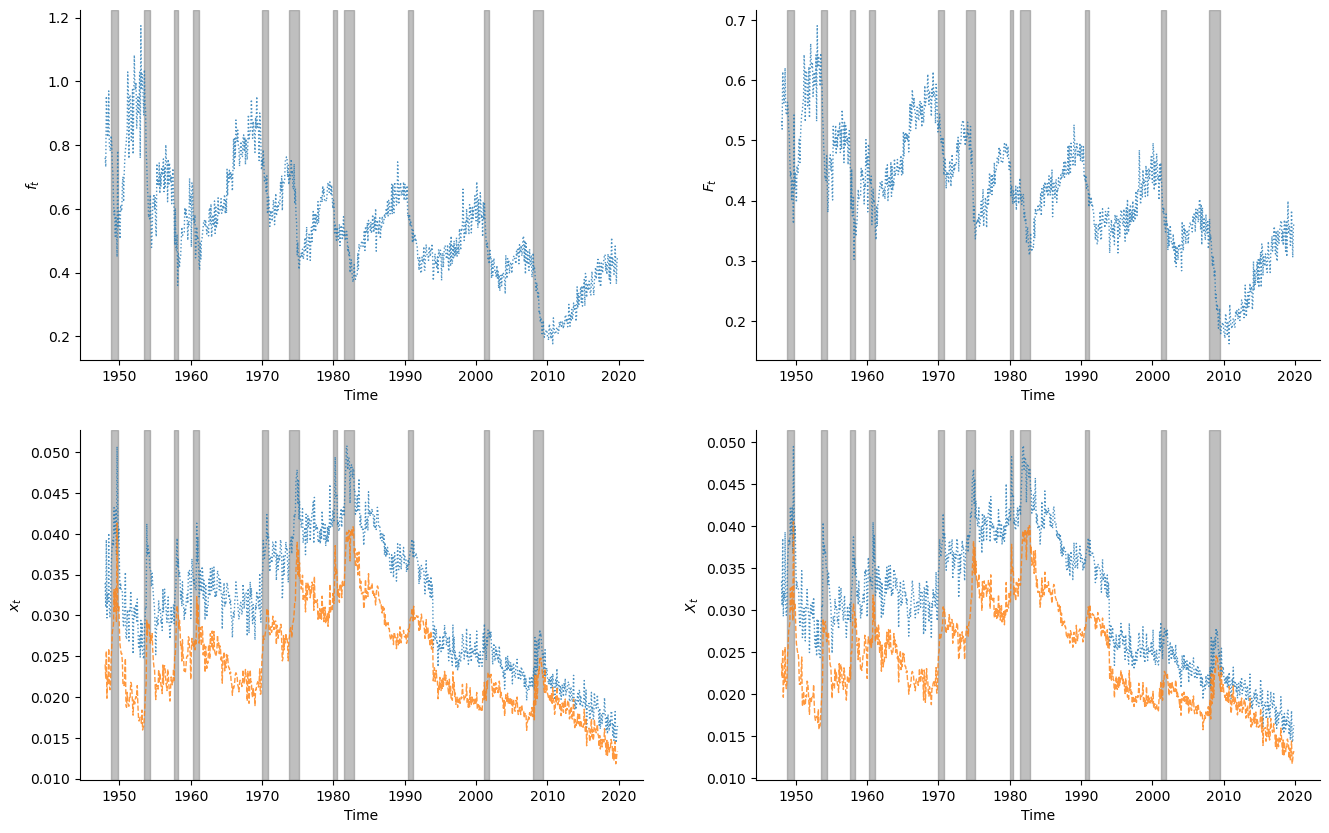

In [10]:
using PyPlot, LaTeXStrings

fig1, axes1 = subplots(2,2,figsize=(16, 10))

#fig1[:suptitle]("Job finding and separation rates")

ax_jfr = axes1[1,1]
ax_ser = axes1[2,1]
ax_jfp = axes1[1,2]
ax_sep = axes1[2,2]

#     for i = 1:wN
#         ax1[:plot](A_grid, ge[:,i],  linewidth=2, label = w_grid[i], alpha=0.6)
#         ax2[:plot](A_grid, gu[:,i],  linewidth=2, label = w_grid[i], alpha=0.6)
#     end
    
ax_jfr.plot(months[1:end-1], f, linestyle = ":",  linewidth=1, alpha=0.8)
ax_ser.plot(months[1:end-1], x, linestyle = ":",  linewidth=1, alpha=0.8, label = L"x_t")  
ax_jfp.plot(months[1:end-1], F, linestyle = ":",  linewidth=1, alpha=0.8)
ax_sep.plot(months[1:end-1], X, linestyle = ":",  linewidth=1, alpha=0.8, label = L"X_t") 

ax_sep.plot(months[1:end-1], X_tilde, linestyle = "--",  linewidth=1, alpha=0.8, label = L"\tilde{X}_t") 
ax_ser.plot(months[1:end-1], x_tilde, linestyle = "--",  linewidth=1, alpha=0.8, label = L"\tilde{X}_t")  

ax_jfr.set_xlabel("Time")
ax_jfr.set_ylabel(L"f_t")
ax_ser.set_xlabel("Time")
ax_ser.set_ylabel(L"x_t")
ax_jfp.set_xlabel("Time")
ax_jfp.set_ylabel(L"F_t")
ax_sep.set_xlabel("Time")
ax_sep.set_ylabel(L"X_t")

ax_jfr.spines["top"].set_color("none") # Remove the top axis boundary
ax_jfr.spines["right"].set_color("none") # Remove the right axis boundary
ax_ser.spines["top"].set_color("none") # Remove the top axis boundary
ax_ser.spines["right"].set_color("none") # Remove the right axis boundary
ax_jfp.spines["top"].set_color("none") # Remove the top axis boundary
ax_jfp.spines["right"].set_color("none") # Remove the right axis boundary
ax_sep.spines["top"].set_color("none") # Remove the top axis boundary
ax_sep.spines["right"].set_color("none") # Remove the right axis boundary

### Add recession indicators

for i = 1:length(rec_startdates)
    ax_jfr.axvspan(rec_startdates[i],rec_enddates[i],color = "grey", alpha=0.5) # Recession
    ax_jfp.axvspan(rec_startdates[i],rec_enddates[i],color = "grey", alpha=0.5) # Recession
    ax_ser.axvspan(rec_startdates[i],rec_enddates[i],color = "grey", alpha=0.5) # Recession
    ax_sep.axvspan(rec_startdates[i],rec_enddates[i],color = "grey", alpha=0.5) # Recession
end

The monthly data is quite noisy for the graphs, so as Shimer we proceed by constructing quarterly averages of the monthly data (these will be used only for graphs).

### Now, as Shimer, actually convert the data to quarterly averages

In [11]:
# At each month, calculate the average of each series over the next three months
f_qr1 = similar(f[1:end-2]) 
F_qr1, x_qr1, X_qr1, x_tilde_qr1, X_tilde_qr1, u_qr1 = similar(f_qr1),similar(f_qr1),similar(f_qr1),similar(f_qr1),similar(f_qr1), similar(f_qr1)

for i = 1:length(f)-2
    f_qr1[i] = (f[i]+f[i+1]+f[i+2])/3
    F_qr1[i] = (F[i]+F[i+1]+F[i+2])/3
    x_qr1[i] = (x[i]+x[i+1]+x[i+2])/3
    X_qr1[i] = (X[i]+X[i+1]+X[i+2])/3
    x_tilde_qr1[i] = (x_tilde[i]+x_tilde[i+1]+x_tilde[i+2])/3
    X_tilde_qr1[i] = (X_tilde[i]+X_tilde[i+1]+X_tilde[i+2])/3
    u_qr1[i] = (u[i]+u[i+1]+u[i+2])/3
end

In [12]:
# And keep only the months at which quarters begin, ending up with quarterly data (aggregated from months)
f_qr = f_qr1[1:3:end];
F_qr = F_qr1[1:3:end];
x_qr = x_qr1[1:3:end];
X_qr = X_qr1[1:3:end];
x_tilde_qr = x_tilde_qr1[1:3:end];
X_tilde_qr = X_tilde_qr1[1:3:end];
u_qr = u_qr1[1:3:end];
qr = months[1:3:end-3]; # note end-3 here because the series on rates by construction were shorter (see above) 

Let's plot the quarterly data

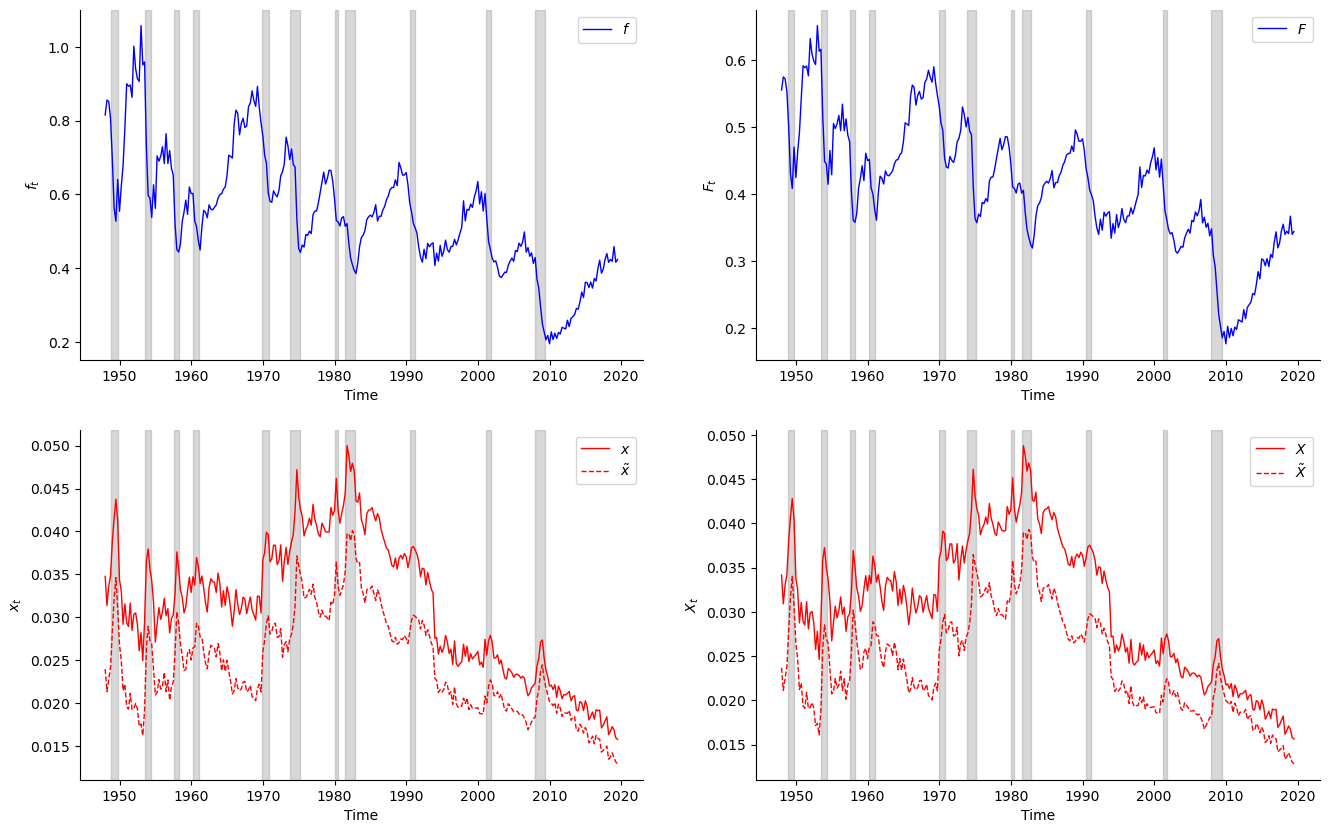

In [13]:
fig1, axes1 = subplots(2,2,figsize=(16, 10))

#fig1[:suptitle]("Job finding and separation rates")

ax_jfr = axes1[1,1]
ax_ser = axes1[2,1]
ax_jfp = axes1[1,2]
ax_sep = axes1[2,2]
    
ax_jfr.plot(qr, f_qr, linestyle = "-", linewidth=1, alpha=1, color = "blue", label=L"f")
ax_ser.plot(qr, x_qr, linestyle = "-", linewidth=1, alpha=1, color = "red", label=L"x")  
ax_jfp.plot(qr, F_qr, linestyle = "-", linewidth=1, alpha=1, color = "blue", label=L"F")
ax_sep.plot(qr, X_qr, linestyle = "-", linewidth=1, alpha=1, color = "red", label=L"X") 

ax_ser.plot(qr, x_tilde_qr, linestyle = "--", linewidth=1, alpha=1, color = "red", label=L"\tilde{x}")  
ax_sep.plot(qr, X_tilde_qr, linestyle = "--", linewidth=1, alpha=1, color = "red", label=L"\tilde{X}") 

ax_jfr.legend()
ax_ser.legend()
ax_jfp.legend()
ax_sep.legend()


ax_jfr.set_xlabel("Time")
ax_jfr.set_ylabel(L"f_t")
ax_ser.set_xlabel("Time")
ax_ser.set_ylabel(L"x_t")
ax_jfp.set_xlabel("Time")
ax_jfp.set_ylabel(L"F_t")
ax_sep.set_xlabel("Time")
ax_sep.set_ylabel(L"X_t")

ax_jfr.spines["top"].set_color("none") # Remove the top axis boundary
ax_jfr.spines["right"].set_color("none") # Remove the right axis boundary
ax_ser.spines["top"].set_color("none") # Remove the top axis boundary
ax_ser.spines["right"].set_color("none") # Remove the right axis boundary
ax_jfp.spines["top"].set_color("none") # Remove the top axis boundary
ax_jfp.spines["right"].set_color("none") # Remove the right axis boundary
ax_sep.spines["top"].set_color("none") # Remove the top axis boundary
ax_sep.spines["right"].set_color("none") # Remove the right axis boundary

for i = 1:length(rec_startdates)
    ax_jfr.axvspan(rec_startdates[i],rec_enddates[i],color = "grey", alpha=0.3) # Recession
    ax_jfp.axvspan(rec_startdates[i],rec_enddates[i],color = "grey", alpha=0.3) # Recession
    ax_ser.axvspan(rec_startdates[i],rec_enddates[i],color = "grey", alpha=0.3) # Recession
    ax_sep.axvspan(rec_startdates[i],rec_enddates[i],color = "grey", alpha=0.3) # Recession
end

Looks much nicer than the monthly! Don't underestimate the value of a smooth graph!

Let's check a few claims from Shimer:

In [14]:
using Statistics

Xbar = mean(X_qr)
Fbar = mean(F_qr)
Xtildebar = mean(X_tilde_qr)

Xhat = std(X_qr)
Fhat = std(F_qr)
Xtildehat = std(X_tilde_qr)

println("E(F) = $Fbar")
println("SD(F) = $Fhat")

println("E(X) = $Xbar")
println("SD(X) = $Xhat")

println(L"E($\tilde{X}$)", " = $Xtildebar")
println(L"SD($\tilde{X}$)", " = $Xtildehat")


E(F) = 0.4120320655041345
SD(F) = 0.09542364195762039
E(X) = 0.030898028269384866
SD(X) = 0.007584445800529077
E($\tilde{X}$) = 0.024133653519334105
SD($\tilde{X}$) = 0.005775263722745062


We can see that 

1. job-finding probabilities are of orders of magnitude larger than job separation (more than 10-fold) on average
2. job-finding probabilities are more volatile than separations
3. the "correctly" measured job separation probabilities are higher than it appears due to time aggregation. They also appear more volatile overall.

Now we can detrend the data. The below cell defines a function `hp_filter()` which takes a data series and a smoothing parameter and fits the HP-trend for the series. Check the Wikipedia article on Hodrick-Prescott filter for more details.

In [15]:
using SparseArrays 


function hp_filter(y::Vector{Float64}, lambda::Float64)
    n = length(y)
    @assert n >= 4

    diag2 = lambda*ones(n-2)
    diag1 = [ -2lambda; -4lambda*ones(n-3); -2lambda ]
    diag0 = [ 1+lambda; 1+5lambda; (1+6lambda)*ones(n-4); 1+5lambda; 1+lambda ]

    D = spdiagm(-2 => diag2, -1 => diag1, 0 => diag0, 1 => diag1, 2 => diag2)

    D\y
end

hp_filter (generic function with 1 method)

Now just obtain the trends using smoothing parameter $10^5$ - as Shimer.

In [16]:
tau_X=hp_filter(X_qr, 100000.0);
tau_F=hp_filter(F_qr, 100000.0);
tau_X_tilde=hp_filter(X_tilde_qr, 100000.0);

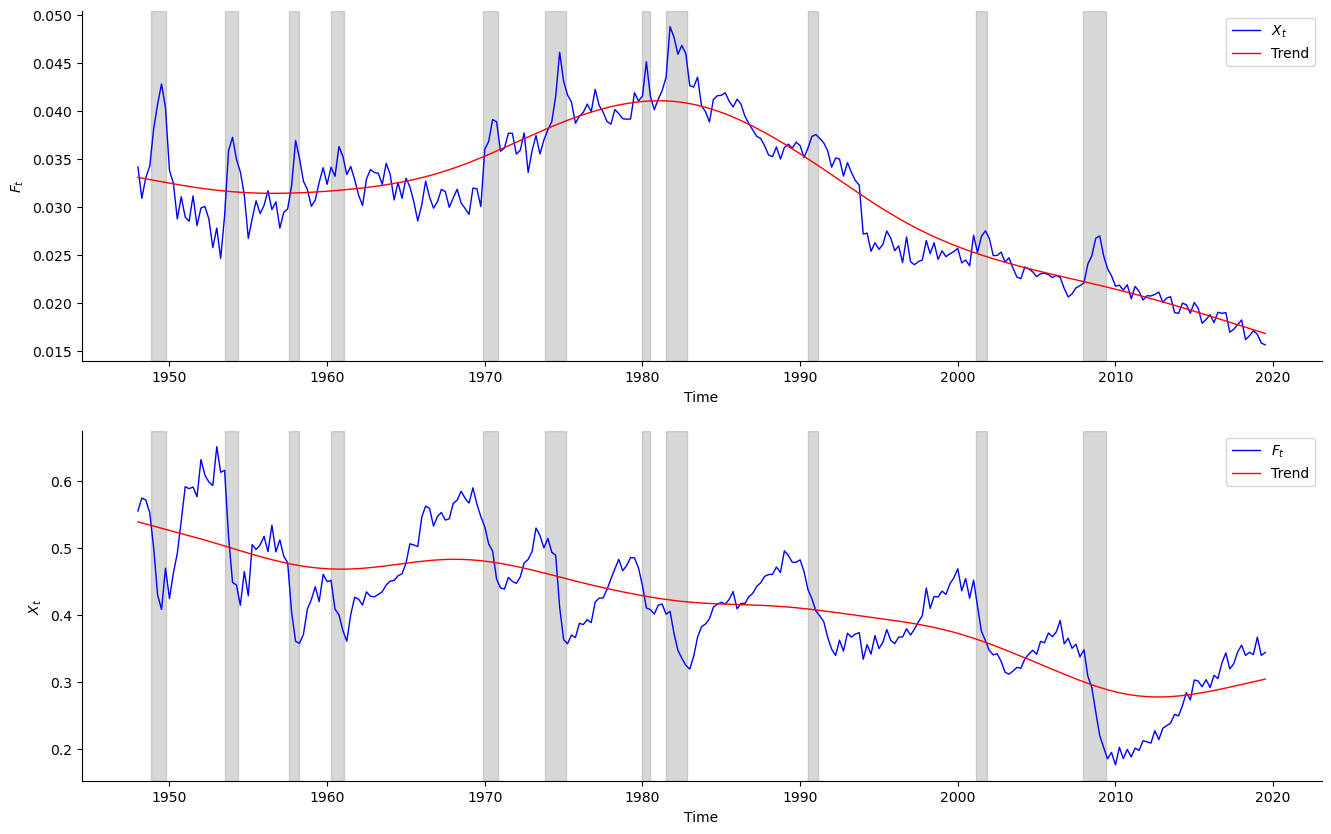

In [17]:
fig1, axes = subplots(2,1,figsize=(16, 10))

axF = axes[1]
axS = axes[2]

axF.plot(qr, X_qr,  linewidth=1, alpha=1, color = "blue", label = L"X_t")
axF.plot(qr, tau_X,  linewidth=1, alpha=1, color = "red", label = "Trend")

axS.plot(qr, F_qr,  linewidth=1, alpha=1, color = "blue", label = L"F_t")  
axS.plot(qr, tau_F,  linewidth=1, alpha=1, color = "red", label = "Trend")  


axF.legend()
axS.legend()

axS.set_xlabel("Time")
axS.set_ylabel(L"X_t")

axF.set_xlabel("Time")
axF.set_ylabel(L"F_t")

axF.spines["top"].set_color("none") # Remove the top axis boundary
axF.spines["right"].set_color("none") # Remove the right axis boundary
axS.spines["top"].set_color("none") # Remove the top axis boundary
axS.spines["right"].set_color("none") # Remove the right axis boundary

for i = 1:length(rec_startdates)
    axF.axvspan(rec_startdates[i],rec_enddates[i],color = "grey", alpha=0.3) # Recession
    axS.axvspan(rec_startdates[i],rec_enddates[i],color = "grey", alpha=0.3) # Recession
end

Let's verify some basic facts about the volatility of the cyclical component of the series, using standard deviations:

In [18]:
X_hp = (X_qr - tau_X)./tau_X;
F_hp = (F_qr - tau_F)./tau_F;
Xt_hp = (X_tilde_qr - tau_X_tilde)./tau_X_tilde;

stdX_hp = std(X_hp)
stdXt_hp = std(Xt_hp)
stdF_hp = std(F_hp)

println("SD(Xhp) = $stdX_hp")
println("SD(Xthp) = $stdXt_hp")
println("SD(Fhp) = $stdF_hp")

SD(Xhp) = 0.07781042471716641
SD(Xthp) = 0.10858060106661237
SD(Fhp) = 0.1357934813697935


Note that

1. The cyclical volatility of the job-finding probability is higher than of separation probability.
2. The cyclical volatility of the job-separation probability is considerably lower than it appears if we don't correct for time aggregation.

### Now on the same axis

Plot of the percentage deviations away from the trends

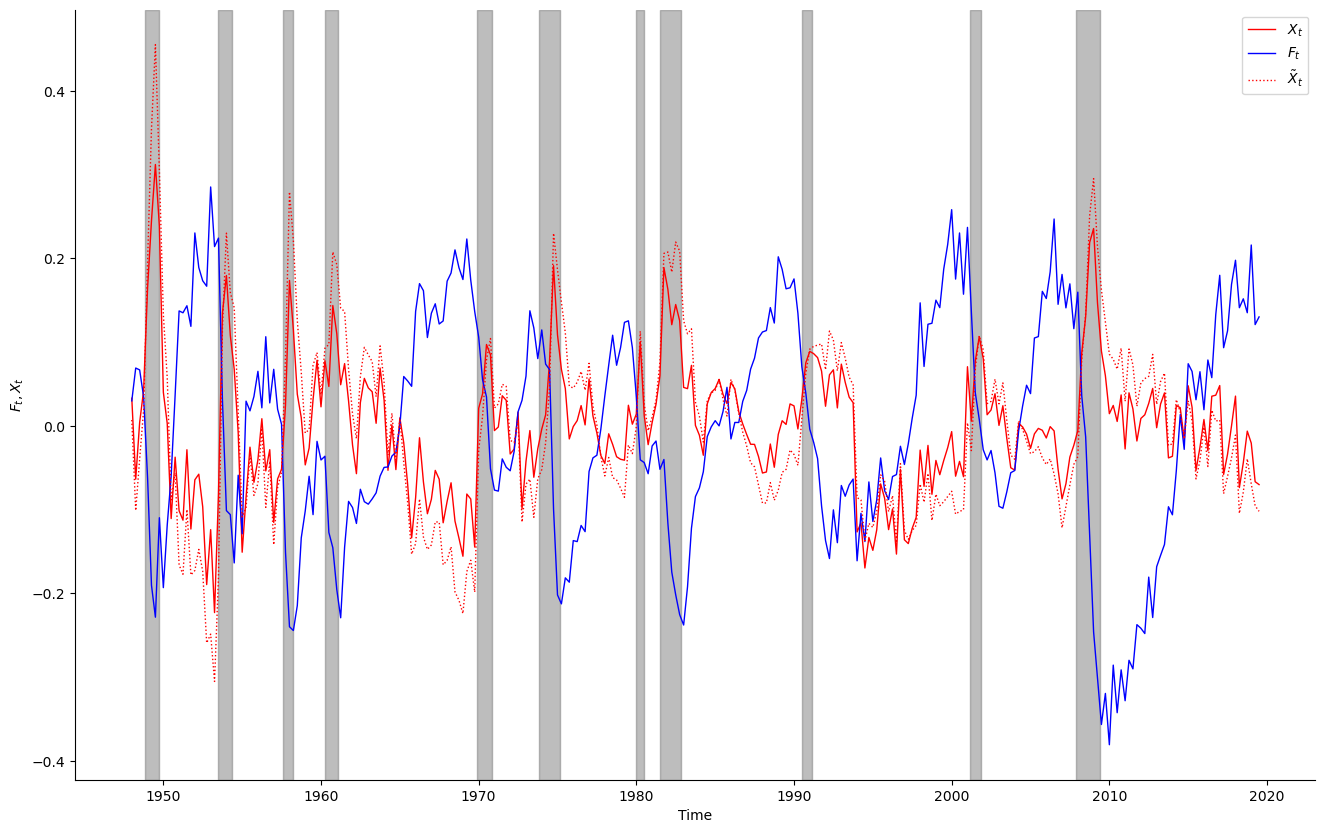

In [19]:
fig1, axes = subplots(1,1,figsize=(16, 10))
    
axes.plot(qr, X_hp,  linewidth=1, alpha=1, color = "red", label = L"X_t")
axes.plot(qr, F_hp,  linewidth=1, alpha=1, color = "blue", label = L"F_t")  
axes.plot(qr, Xt_hp,  linewidth=1, alpha=1, linestyle = ":", color = "red", label = L"\tilde{X}_t")  


axes.legend()

axes.set_xlabel("Time")
axes.set_ylabel(L"F_t, X_t")


axes.spines["top"].set_color("none") # Remove the top axis boundary
axes.spines["right"].set_color("none") # Remove the right axis boundary

for i = 1:length(rec_startdates)
    axes.axvspan(rec_startdates[i],rec_enddates[i],color = "grey", alpha=0.3) # Recession
    axes.axvspan(rec_startdates[i],rec_enddates[i],color = "grey", alpha=0.3) # Recession
end

## Check the claim of correlation between unemployment and ratio of rates

Now construct the object

$$u^0_t = \frac{x_t}{x_t+f_t}$$

and check how it relates to unemployment


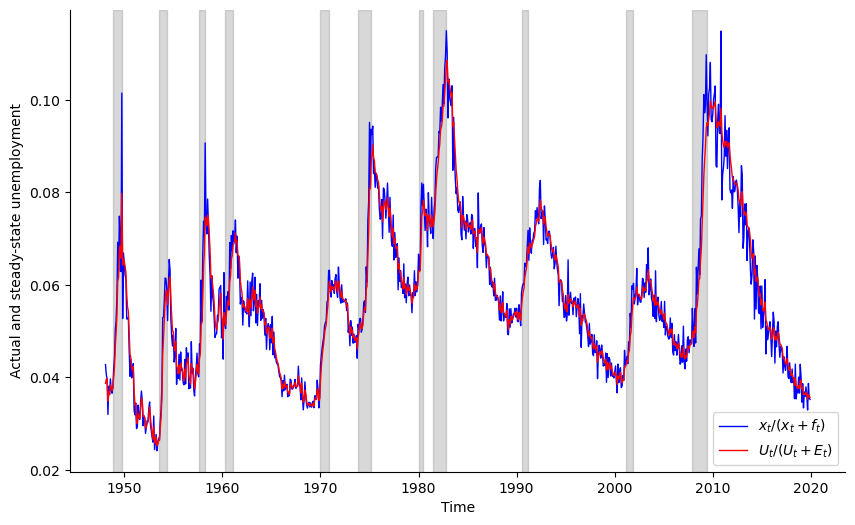

In [20]:
# In monthly data
fig1, axes1 = subplots(figsize=(10, 6))
    
axes1.plot(months[2:end], u0,  linewidth=1, alpha=1, label = L"x_t/(x_t+f_t)", color ="blue")
axes1.plot(months[2:end], u,  linewidth=1, alpha=1, label = L"$U_{t}/(U_t+E_t)$",color ="red" )   

axes1.set_xlabel("Time")
axes1.set_ylabel("Actual and steady-state unemployment")

axes1.legend()

axes1.spines["top"].set_color("none") # Remove the top axis boundary
axes1.spines["right"].set_color("none") # Remove the right axis boundary

for i = 1:length(rec_startdates)
    axes1.axvspan(rec_startdates[i],rec_enddates[i],color = "grey", alpha=0.3) # Recession
end

In [21]:
cor(u0,u)

0.9822154940677467

Looks essentially like the same series.

It looks even neater in quarterly data (although it is important that it's close in the monthly data):

In [22]:
u0_qr = (x_qr./(x_qr.+f_qr));

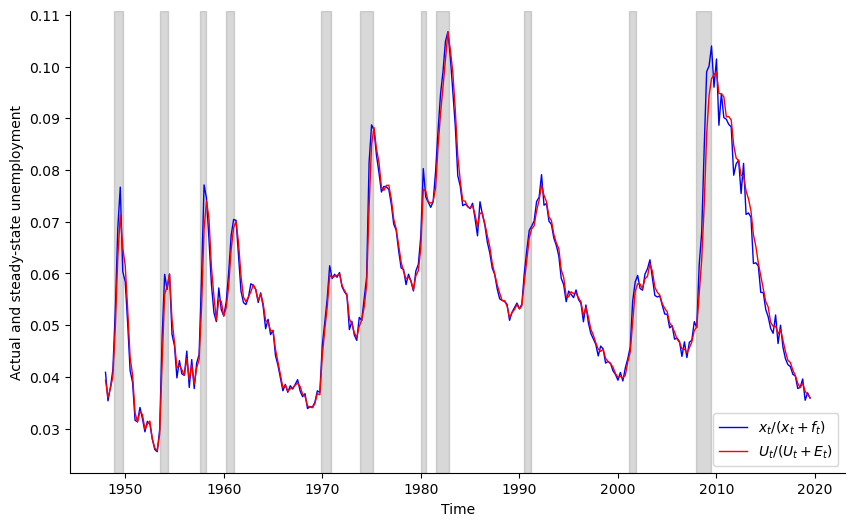

In [23]:
fig1, axes1 = subplots(figsize=(10, 6))
    
axes1.plot(qr, u0_qr,  linewidth=1, alpha=1, label = L"x_t/(x_t+f_t)", color ="blue")
axes1.plot(qr, u_qr,  linewidth=1, alpha=1, label = L"$U_{t}/(U_t+E_t)$",color ="red" )   

axes1.set_xlabel("Time")
axes1.set_ylabel("Actual and steady-state unemployment")

axes1.legend()

axes1.spines["top"].set_color("none") # Remove the top axis boundary
axes1.spines["right"].set_color("none") # Remove the right axis boundary

for i = 1:length(rec_startdates)
    axes1.axvspan(rec_startdates[i],rec_enddates[i],color = "grey", alpha=0.3) # Recession
end

In [24]:
cor(u0_qr,u_qr)

0.9912982083448778

## The decomposition exercise

Let $\bar{x}$ and $\bar{f}$ denote the sample average values of $x_t$ and $f_t$. Then construct the objects $\frac{\bar{x}}{\bar{x}+f_t}$ and $\frac{x_t}{x_t+\bar{f}}$.

In [25]:
xbar = mean(x)
fbar = mean(f)

f_contr = similar(f)
x_contr = similar(x)

for i in 1:length(f)
    f_contr[i] = xbar/(xbar+f[i])
    x_contr[i] = x[i]/(x[i]+fbar)
end

For a smoother graph let's take the quarterly averages again

In [26]:
f1_qr_contr = similar(f[1:end-2])
x1_qr_contr = similar(f[1:end-2])

for i in 1:length(f_contr)-2
    f1_qr_contr[i] = (f_contr[i]+f_contr[i+1]+f_contr[i+2])/3 
    x1_qr_contr[i] = (x_contr[i]+x_contr[i+1]+x_contr[i+2])/3
end

f_qr_contr = f1_qr_contr[1:3:end];
x_qr_contr = x1_qr_contr[1:3:end];

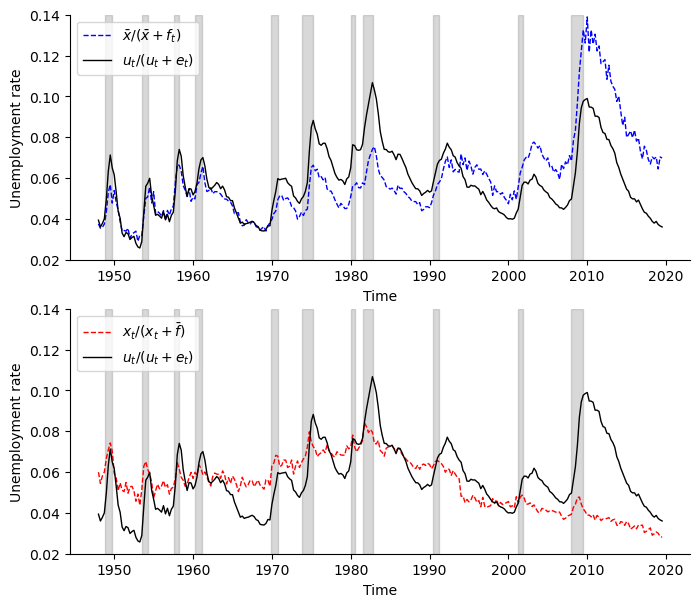

In [27]:
fig1, axes1 = subplots(2,1,figsize=(8, 7))

ax_f = axes1[1]
ax_x = axes1[2]

ax_f.plot(qr, f_qr_contr,  linewidth=1, alpha=1, linestyle = "--", color = "blue", label = L"\bar{x}/(\bar{x}+f_t)")
ax_f.plot(qr, u_qr,  linewidth=1, alpha=1, color = "black", label = L"u_t/(u_t+e_t)")
ax_f.legend(loc=2)

ax_x.plot(qr, x_qr_contr,  linewidth=1, alpha=1, linestyle = "--", color = "red", label = L"x_t/(x_t+\bar{f})")  
ax_x.plot(qr, u_qr,  linewidth=1, alpha=1, color = "black", label = L"u_t/(u_t+e_t)")
ax_x.legend(loc=2)


ax_f.set_xlabel("Time")
ax_f.set_ylabel("Unemployment rate")
ax_f.set_ylim([0.02,0.14])
ax_x.set_xlabel("Time")
ax_x.set_ylabel("Unemployment rate")
ax_x.set_ylim([0.02,0.14])


ax_f.spines["top"].set_color("none") # Remove the top axis boundary
ax_f.spines["right"].set_color("none") # Remove the right axis boundary
ax_x.spines["top"].set_color("none") # Remove the top axis boundary
ax_x.spines["right"].set_color("none") # Remove the right axis boundar

for i = 1:length(rec_startdates)
    ax_f.axvspan(rec_startdates[i],rec_enddates[i],color = "grey", alpha=0.3) # Recession
    ax_x.axvspan(rec_startdates[i],rec_enddates[i],color = "grey", alpha=0.3) # Recession
end

## Now the quantitative decomposition

Covariance of $\frac{u_{t+1}}{l_{t+1}}$ and $\frac{\bar{x}}{\bar{x}+f_t}$ or $\frac{x_t}{x_t+\bar{f}}$ divided by variance of $\frac{u_{t+1}}{l_{t+1}}$ where all series are 
1. quarterly averages of monthly data
2. detrended using an HP filter with parameter $10^5$.

decomposing the cyclical volatility of unemployment into a component due to its covariation with the cyclical components of the two counterfactual series.

In [28]:
ur_qr_f = u_qr
ur_hp = (ur_qr_f - hp_filter(ur_qr_f, 100000.0))./hp_filter(ur_qr_f, 100000.0)
f_qr_hp = (f_qr_contr - hp_filter(f_qr_contr, 100000.0))./hp_filter(f_qr_contr, 100000.0)
x_qr_hp = (x_qr_contr - hp_filter(x_qr_contr, 100000.0))./hp_filter(x_qr_contr, 100000.0);

In [29]:
cov(ur_hp, x_qr_hp)/var(ur_hp)

0.22407030526107502

In [30]:
cov(ur_hp, f_qr_hp)/var(ur_hp)

0.776900613863917

These are the contributions.